In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/my_ml_2023/session-8

In [ ]:
import tensorflow  as tf
from torchvision import transforms, models
# import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils



# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

In [ ]:
from sklearn.metrics import accuracy_score

def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred, y_test)

# MNIST

The MNIST is database of handwritten digits containing a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

In [ ]:
(train_dev_images, train_dev_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from sklearn.model_selection import train_test_split
train_images, dev_images, train_labels, dev_labels = train_test_split(train_dev_images, train_dev_labels, test_size=10000,
                                                    random_state=1234, stratify=train_dev_labels)

In [ ]:
print(train_images.shape)
print(dev_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(dev_labels.shape)
print(test_labels.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)
(50000,)
(10000,)
(10000,)


First, we need to convert grayscale images with 1 channel to rgb images with 3 channels because most of the big CNNs were designed that way.

In [ ]:
preprocess_images = transforms.Compose([transforms.ToPILImage(),
                                        lambda x: x.convert("RGB"),
                                        transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])


In [ ]:
train_images = torch.stack([preprocess_images(img) for img in train_images], dim=0)
dev_images = torch.stack([preprocess_images(img) for img in dev_images], dim=0)
test_images = torch.stack([preprocess_images(img) for img in test_images], dim=0)

In [ ]:
print(train_images.shape)
print(dev_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(dev_labels.shape)
print(test_labels.shape)

NameError: name 'train_images' is not defined

As usual, we need to covert data to the `PyTorch` format.

In [ ]:
def np2iter(x, y, shuffle=True):

  ds = torch.utils.data.TensorDataset(x,
                                      torch.tensor(y, dtype=torch.long))
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(train_images, train_labels, shuffle=True)
dev_iter =  np2iter(dev_images, dev_labels, shuffle=False)
test_iter =  np2iter(test_images, test_labels, shuffle=False)

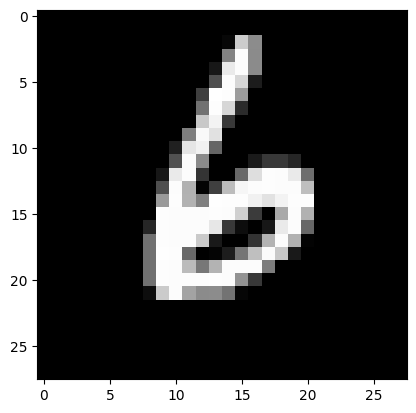

In [ ]:
plt.imshow(train_images[0][0], cmap='gray')

Let's build our first simple CNN with 2 convolutional layers. In each layer (or block), we always  one `Conv2D` layer, which we feed through a `MaxPool2D` to reduce the size of the input. The parameters of the Conv2D block require a bit more explanation: the first layer (`nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)`) has 32 filters/out_channels that each will be sled across the entire input (which is an image in the beggining, and a feature map later). Their **receptive field or kernel's size**  is three by three, meaning that the patterns which it will detect will be in a square of three by three. As we keep on stacking convolutions, you will often see that the number of filters goes up: that is deliberate and based on the assumption that higher layers in the network have to detect increasingly complex patterns.

In [ ]:

class SimpleModel(nn.Module):
  def __init__(self):
    super(SimpleModel, self).__init__()
    # in_channels, out_channels, kernel_size,
    self.cnn =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                                nn.ReLU(),
                                nn.MaxPool2d(2),

                                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                nn.ReLU(),
                                nn.MaxPool2d(2))

    self.linear =  nn.Sequential(nn.Linear(64 * 5 * 5, 128),
                                nn.Linear(128, 10))


  def forward(self, x):
    x = self.cnn(x)
    # print(x.shape)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    x = self.linear(x)
    return x




In [ ]:
simple_cnn = SimpleModel()
simple_cnn = simple_cnn.cuda()

history = utils.train(model=simple_cnn,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(simple_cnn.parameters(), lr=1e-5),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=4)

epoch 1 train loss: 1.7098 val_cls: 0.9384 val_acc: 0.8348
epoch 2 train loss: 0.6193 val_cls: 0.4506 val_acc: 0.8816
epoch 3 train loss: 0.3765 val_cls: 0.3279 val_acc: 0.9088
epoch 4 train loss: 0.2932 val_cls: 0.2703 val_acc: 0.9236


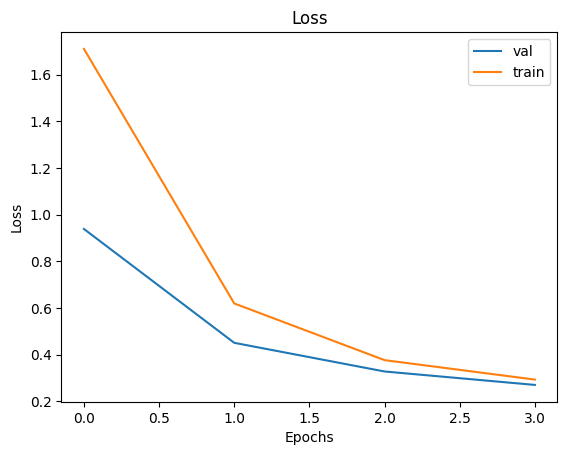

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

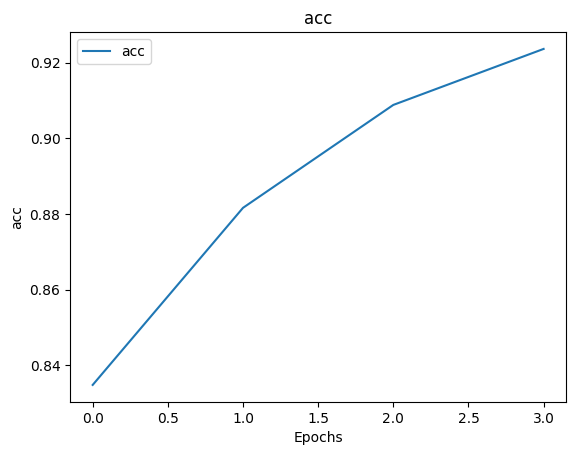

In [ ]:
plt.plot(history['val_acc'],  label='acc')
plt.title('acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
simple_pred = utils.test(simple_cnn, test_iter)
simple_pred = np.argmax(simple_pred, axis=1)
simple_pred[:5]

tensor([7, 2, 1, 0, 4])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
print(classification_report(y_pred=simple_pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.94      0.89      0.91      1032
           3       0.92      0.93      0.93      1010
           4       0.93      0.95      0.94       982
           5       0.92      0.92      0.92       892
           6       0.94      0.95      0.94       958
           7       0.92      0.91      0.91      1028
           8       0.92      0.89      0.90       974
           9       0.92      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# Deep pre-trained CCNs

In [ ]:
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, 10, bias=True)
resnet18 = resnet18.cuda()

history = utils.train(model=resnet18,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(resnet18.parameters(), lr=1e-5),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=4)

epoch 1 train loss: 0.6315 val_cls: 0.2119 val_acc: 0.9429
epoch 2 train loss: 0.1628 val_cls: 0.1233 val_acc: 0.9651
epoch 3 train loss: 0.0943 val_cls: 0.0931 val_acc: 0.9726
epoch 4 train loss: 0.0605 val_cls: 0.0802 val_acc: 0.9768


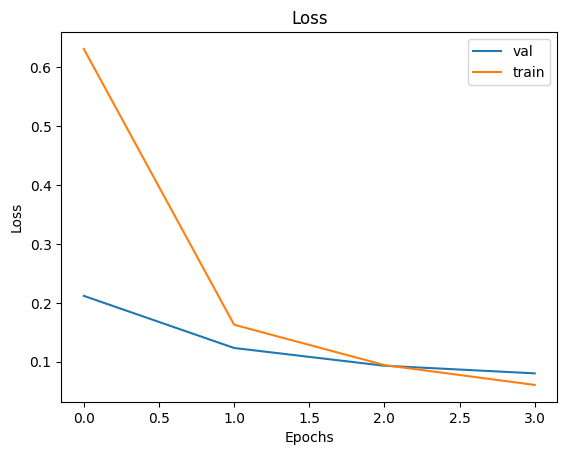

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

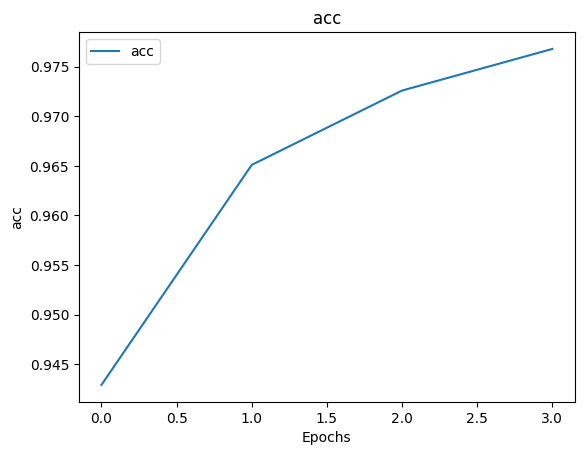

In [ ]:
plt.plot(history['val_acc'],  label='acc')
plt.title('acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
resnet18_pred = utils.test(resnet18, test_iter)
resnet18_pred = np.argmax(resnet18_pred, axis=1)
resnet18_pred[:5]

tensor([7, 2, 1, 0, 4])

In [ ]:
print(classification_report(y_pred=resnet18_pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.95      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
resnet18_pretrained = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18_pretrained.fc = nn.Linear(512, 10, bias=True)
resnet18_pretrained = resnet18_pretrained.cuda()

history = utils.train(model=resnet18_pretrained,
                            loss=nn.CrossEntropyLoss(),
                            val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                            optimizer=torch.optim.Adam(resnet18_pretrained.parameters(), lr=1e-5),
                            train_ds=train_iter,
                            dev_ds=dev_iter,
                            num_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


epoch 1 train loss: 0.6784 val_cls: 0.1437 val_acc: 0.9623
epoch 2 train loss: 0.1343 val_cls: 0.0749 val_acc: 0.9788
epoch 3 train loss: 0.0829 val_cls: 0.0558 val_acc: 0.9842
epoch 4 train loss: 0.0570 val_cls: 0.0469 val_acc: 0.9867


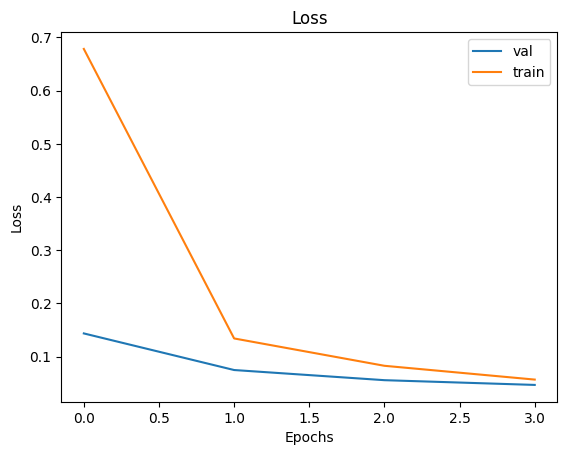

In [ ]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

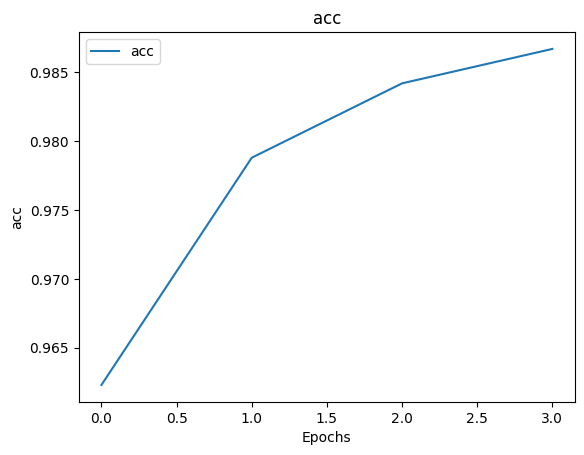

In [ ]:
plt.plot(history['val_acc'],  label='acc')
plt.title('acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
resnet18pretrained_pred = utils.test(resnet18_pretrained, test_iter)
resnet18pretrained_pred = np.argmax(resnet18pretrained_pred, axis=1)
resnet18pretrained_pred[:5]

tensor([7, 2, 1, 0, 4])

In [ ]:
print(classification_report(y_pred=resnet18pretrained_pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.98      0.99      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### **Take-Home Message**:

1. **Use Established Architectures**: Pre-optimized architectures (like VGG, ResNet, etc.) often perform better than custom-built ones. For your work/research, starting with these well-tested models is usually more effective and efficient.

2. **Leverage Pre-Trained Models**: Networks pre-trained on large datasets (e.g., ImageNet) typically deliver better results, especially for tasks with limited data. However, if your task is simple or you have a large dataset to train on, the performance gap between pre-trained models and training from scratch may be minimal.